**Importe Packages**

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial import distance
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Importe Sunspots Time series**

In [14]:
data=pd.read_csv("Sunspots.csv")
data

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8


In [15]:
len(data)

3265

**Preprocessing**

In [16]:
series = np.array(data["Monthly Mean Total Sunspot Number"])
time =data.index
data.index

RangeIndex(start=0, stop=3265, step=1)

In [17]:
data['Date']= pd.to_datetime(data['Date'])

In [18]:
data.set_index(['Date'], inplace=True)

**Split data**

In [19]:
split_ratio = 0.8  # 80% for training
split_time = int(len(series) * split_ratio)

time_train = time[:split_time]
X_train = series[:split_time]
time_test = time[split_time:]
X_test = series[split_time:]

**Figure**

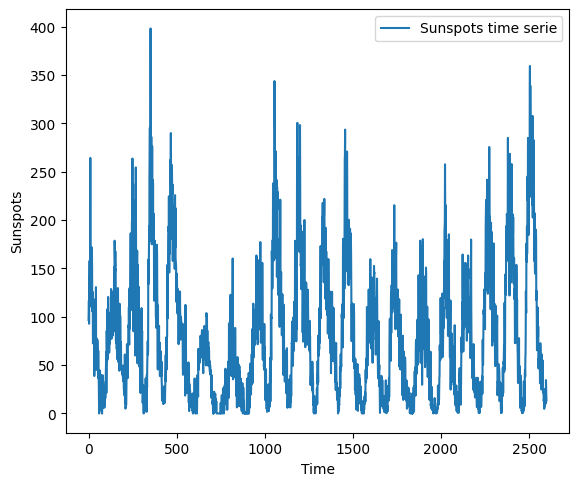

In [20]:
plt.figure(figsize=(6.5,5.5))
plt.plot(np.arange(0,2600), X_train[0:2600], label="Sunspots time serie")

plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.legend()
plt.savefig('/content/Sunspots.png', dpi=300, bbox_inches='tight')
plt.show()

# Double Vector Quantization based on PrSOM





# **Method description**

The Double Vector Quantization (DVQ) model enhanced by Probabilistic Self-Organizing Maps (PrSOM) is a two-phase approach dedicated to time series forecasting. This method begins by transforming the original series into two spaces: the regressor space, which contains vectors of consecutive past observations, and the deformation space, which captures the variation between successive regressors. Both spaces are clustered separately using the PrSOM algorithm, which not only identifies representative prototypes but also provides probabilistic associations, offering a more nuanced understanding of the underlying data structure. After clustering, a transition matrix is constructed to represent the likelihood of moving from a regressor cluster to a deformation cluster, effectively capturing the temporal evolution dynamics of the series. For forecasting, the current regressor is mapped to its most probable cluster, and the model uses the learned transition probabilities to determine the most likely deformation cluster. The predicted future regressor is then generated by applying the corresponding deformation prototype, from which the next value in the time series is extracted. This integration of probabilistic clustering and transition modeling allows DVQ-PrSOM to effectively capture both the structure and the dynamics of complex time series, providing reliable predictions even in non-linear and non-stationary environments such as sunspot activity.

The proposed Double Vector Quantization (DVQ) based on PrSOM code is structured as follows:

### 1. Input and Preprocessing

Given a univariate time series:

$$
x = (x_1, x_2, \ldots, x_n)
$$

- Build regressors $ \mathbf{x}_t \in \mathbb{R}^p$ using a sliding window of size \( p \).
- Compute deformation vectors:

$$
\mathbf{z}_t = \mathbf{x}_{t+1} - \mathbf{x}_t
$$

### 2. Learning Phase (Training)

- Apply **Probabilistic Self-Organizing Map (PrSOM)** to cluster:
  - The regressor space $\{\mathbf{x}_t\}$ into $n_1 $ clusters.
  - The deformation space  $\{ \mathbf{z}_t \}$  into $ n_2 $ clusters.

- Construct the **transition matrix**:

$$
T(i, j) = \mathbb{P}(\text{Deformation cluster } j \mid \text{Regressor cluster } i)
$$

using the observed transitions between clusters.

### 3. Prediction Phase

To forecast the next value $\hat{x}_{n+1}$, perform:

- Identify the most probable regressor cluster:

$$
k = \arg\max_{i}~p_i(\mathbf{x}_n)
$$

- Select the most likely deformation cluster:

$$
l = \arg\max_{j}~T(k, j)
$$

- Compute the next regressor:

$$
\hat{\mathbf{x}}_{n+1} = \mathbf{x}_n + \bar{\mathbf{z}}_l
$$

- Extract the prediction value:

$$
\hat{x}_{n+1} = \hat{\mathbf{x}}_{n+1}^{(p)}
$$

where $ \hat{\mathbf{x}}_{n+1}^{(p)} $ is the last element of the regressor vector.

$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( \hat{x}_i - x_i \right)^2 }
$$

# **PrSOM class**

In [21]:
class PRROM():
    def __init__(self,p):
         self.Xsh =p
         self.Wsh = 0

    def Temperature(t):
        Tmin = 1
        tmax = 1000
        return Tmin * (Tmin / tmax) ** (t / (tmax - 1))

    @staticmethod
    def Kernel_T(W, T, c2):
        fitness = [0] * PRROM.Wsh
        for c1 in range(PRROM.Wsh):
            fitness[c1] = np.exp(-0.5 * np.linalg.norm(W[c2] - W[c1]) / T)
        return fitness

    @staticmethod
    def voisinage(W, T):
        V = np.zeros((PRROM.Wsh, PRROM.Wsh))
        for c2 in range(PRROM.Wsh):
            fitness = [0] * PRROM.Wsh
            for c1 in range(PRROM.Wsh):
                fitness[c1] = (np.exp(-0.5 * np.linalg.norm(W[c2] - W[c1]) / T)) / sum(PRROM.Kernel_T(W, T, c2))
            V[c2] = fitness
        return V

    @staticmethod
    def Winner(W, X, T, Sigma):
        PRROM.Xsh = X.shape[0]
        G = [0] * PRROM.Xsh
        VG = [0] * PRROM.Xsh
        PRROM.Wsh = W.shape[0]
        Voising = np.zeros((PRROM.Wsh, PRROM.Wsh))
        Voising = PRROM.voisinage(W, T)
        for i in range(PRROM.Xsh):
            fitness = [0] * PRROM.Wsh
            for c2 in range(PRROM.Wsh):
                for c1 in range(PRROM.Wsh):
                    Sigma1 = Sigma[c1] * np.eye(W.shape[1])
                    fitness[c2] += multivariate_normal.pdf(X[i], W[c1], Sigma1) * Voising[c2, c1]
            G[i] = np.argmax(fitness)
            VG[i] = np.max(fitness)
        return G, VG

    @staticmethod
    def MiseJourW(W, X, T, Sigma):
        PRROM.Wsh = W.shape[0]
        PRROM.Xsh = X.shape[0]
        Xi = [0] * PRROM.Xsh
        pXi = [0] * PRROM.Xsh
        Xi, pXi = PRROM.Winner(W, X, T, Sigma)
        Voising = np.zeros((PRROM.Wsh, PRROM.Wsh))
        Voising = PRROM.voisinage(W, T)
        Wm = np.zeros((PRROM.Wsh, W.shape[1]))
        for c1 in range(PRROM.Wsh):
            z = np.zeros(W.shape[1])
            const = 0
            Sigma1 = Sigma[c1] * np.eye(W.shape[1])
            for i in range(PRROM.Xsh):
                z += (X[i] * multivariate_normal.pdf(X[i], W[c1], Sigma1) * Voising[Xi[i], c1]) / pXi[i]
                const += (multivariate_normal.pdf(X[i], W[c1], Sigma1) * Voising[Xi[i], c1]) / pXi[i]
            if const!=0:
              Wm[c1] = z / const
            else:
              const=0.00001
        return Wm

    @staticmethod
    def MiseJourSigma(W,X,T,Sigma):
      Xi=[0]*PRROM.Xsh
      pXi=[0]*PRROM.Xsh
      Xi,pXi=PRROM.Winner(W,X,T,Sigma)
      Voising=np.zeros((PRROM.Wsh,PRROM.Wsh))
      Voising=PRROM.voisinage(W,T)
      SigmaM=np.zeros(PRROM.Wsh)
      for c1 in range(PRROM.Wsh):
        d=0
        const=0
        Sigma1=Sigma[c1]*np.eye(W.shape[1])
        for i in range(PRROM.Xsh):
            multivariat=multivariate_normal.pdf(X[i],W[c1],Sigma1)
            d+=((np.linalg.norm(X[i]-W[c1])**2)*multivariat*Voising[Xi[i],c1])/pXi[i]
            const+=W.shape[1]*(multivariat*Voising[Xi[i],c1])/pXi[i]
        SigmaM[c1]=d/const
      return SigmaM

    @staticmethod
    def Erreur(W, X, T, Sigma):
        E = 0
        Xi = PRROM.Winner(W, X, T, Sigma)[0]
        Voising = np.zeros((PRROM.Wsh,PRROM.Wsh))
        Voising = PRROM.voisinage(W, T)
        for i in range(PRROM.Xsh):
            h = 0
            for c1 in range(PRROM.Wsh):
                Sigma1 = Sigma[c1] * np.eye(W.shape[1])
                h += multivariate_normal.pdf(X[i], W[c1], Sigma1) * Voising[Xi[i], c1]
            E -= np.log(h)
        return E

    @staticmethod
    def PRSOM(X,p,n1):
        Sigmaa = [random.randint(1, 10000000000) for _ in range(n1)]
        Xbar = np.random.rand(n1,p)
        t = 0
        while t <= 40:
            T = PRROM.Temperature(t)
            WM = PRROM.MiseJourW(Xbar, X, T, Sigmaa)
            SigmaM = PRROM.MiseJourSigma(Xbar, X, T, Sigmaa)
            Xbar = WM
            Sigmaa = SigmaM
            t = t + 1
        return PRROM.Winner(Xbar, X, T, Sigmaa)[0],Xbar,Sigmaa

# **The class associated to Double Vector Quantization based on PrSOM**

In [22]:
class DoubleVectorQuantizationPR(BaseEstimator, RegressorMixin):
    def __init__(self,p,n,T,horizon):
        self.PrSOM = PRROM(p)
        self.p=p
        self.C_i=None
        self.C_j=None
        self.W=0
        self.Wbar=0
        self.Sigmaa=0
        self.Sigmabar=0
        self.n1=n
        self.n2=n
        self.T = T
        self.horizon=horizon
        self.transition_matrix=np.zeros((self.n1,self.n2))

    def create_regressor(self,data):
      L=len(data)-self.p+1
      R=np.zeros((L,self.p))
      for j in range(L):
        k=j
        for i in range(self.p):
            R[j,i]=data[k]
            k=k+1
      return R
    def fit(self, data):
        regressors=np.zeros((len(data)-self.p+1,self.p))
        regressors=self.create_regressor(data)
        deformation=self.create_deformation(regressors,data)
        regressors=regressors[:-1].copy()
        # Create Sigmaa as a list of identity matrices
        self.C_i,self.W,self.Sigmaa = self.PrSOM.PRSOM(regressors,self.p,self.n1)  # Pass Sigmaa to PRSOM
        self.C_j,self.Wbar,self.Sigmabar= self.PrSOM.PRSOM(deformation,self.p,self.n1)  # Pass Sigmaa to PRSOM
        self.transition_matrix = self.calculate_transition_matrix(regressors, deformation)


    def create_deformation(self, regressors,data):
      d=len(data)-self.p
      D=np.zeros((d,self.p))
      for k in range(d):
         for l in range(self.p):
                D[k,l]=regressors[k+1,l]-regressors[k,l]

      return D

    def calculate_transition_matrix(self, regressors, deformation):
        transition_matrix = np.zeros((self.n1,self.n2))
        for i in range(self.n1):
            for j in range(self.n2):
              C=0
              S=0
              for x in range(len(deformation)):
                 if self.C_i[x]==i and self.C_j[x]==j:
                  S=S+1
                 if self.C_i[x]==i:
                  C=C+1
              if C!=0:
                transition_matrix[i, j] =S/C
              else:
                transition_matrix[i, j] =0
        return transition_matrix

    def predict(self,X_train,X_test):
        predictions = []
        R=self.create_regressor(X_train)
        xt= R[-1]
        pro= self.transition_matrix
        for t in range(self.horizon):
          if t==0:
             xt= xt.reshape(1, -1)
          k = self.PrSOM.Winner(self.W, xt, self.T, self.Sigmaa)[0]
          pr = pro[k[0]]
          l = np.argmax(pr)
          z_l = self.Wbar[l, :]
          x_hat = xt + z_l  # Add z_l to vector xt
          predictions.append(x_hat[0, -1] ) # Extract the last known vakues from x_hat
         # Mise à jour de of xt
          xt = np.append(xt[0, 1:], X_test[t]).reshape(1, -1)  # 2D
        return predictions

    def score(self,X_train,X_test):
        #Training
        self.fit(X_train)
        # Prediction
        predictions = self.predict(X_train,X_test)
        # Error
        rmse = np.sqrt(mean_squared_error(X_test, predictions))
        return predictions,rmse

In [23]:
p=5
n=4
T=0.7
horizon=len(X_test)
#apply the DVQ model
DVQ=DoubleVectorQuantizationPR(p,n,T,horizon)
y_prsom,rms=DVQ.score(X_train,X_test)

# **Calcul Errors Metrics for differents models**

In [24]:
y_predict_PR=y_prsom[1:]
Xtest=X_test[:-1]
rmse_PR = np.sqrt(mean_squared_error(y_predict_PR, Xtest))
mae_PR = mean_absolute_error(y_predict_PR, Xtest)
r2_PR = r2_score(y_predict_PR, Xtest)
print("differents errors using double Vector Quantization based on PrSOM")
print("mean squared error (MSE): ",rmse_PR)
print("mean absolute error (MAE):  ",mae_PR)
print("R² : ",r2_PR)

differents errors using double Vector Quantization based on PrSOM
mean squared error (MSE):  4.503233240930148
mean absolute error (MAE):   2.8997031580627013
R² :  0.9955406544799608


# **Visualization results for DVQ based On PrSOM**

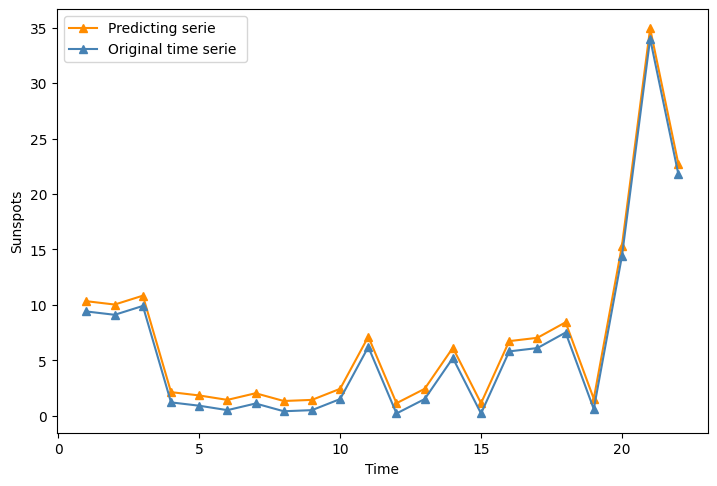

In [25]:
plt.figure(figsize=(8.4,5.5))
start=630
plt.plot(np.arange(1,len(X_test[start:])),y_predict_PR[start:],label="Predicting serie ",color='darkorange', marker='^')
plt.plot(np.arange(1,len(X_test[start:])),Xtest[start:],label="Original time serie ",color='steelblue', marker='^')
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.legend()

Our method is compared against a baseline Simple RNN model to highlight the benefits of using structured vector quantization with probabilistic transitions.

# Reccurent Neural Network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Load the dataset from CSV
df = pd.read_csv("Sunspots.csv")

# Check available columns
print(df.columns)

# Rename column if necessary
if 'Monthly Mean Total Sunspot Number' in df.columns:
    df.rename(columns={'Monthly Mean Total Sunspot Number': 'Sunspots'}, inplace=True)

# Convert "Date" column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Normalize the sunspot data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df['Sunspots'].values.reshape(-1, 1))

# Create sequences for RNN input
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 months = 1 year
X, y = create_sequences(data_scaled, window_size)
X = X.reshape(X.shape[0], X.shape[1], 1)  # 3D shape for RNN

# Split into training and testing sets
split_ratio = 0.8
split_time = int(len(X) * split_ratio)

X_train, X_test = X[:split_time], X[split_time:]
y_train, y_test = y[:split_time], y[split_time:]

# Save original target values for denormalized evaluation
y_test_original = df['Sunspots'].values[-len(y_test):]

# Build the Simple RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the RNN model
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on test set
rnn_predictions = rnn_model.predict(X_test)
# Inverse scaling
rnn_predictions_inv = scaler.inverse_transform(rnn_predictions)

Index(['Unnamed: 0', 'Date', 'Monthly Mean Total Sunspot Number'], dtype='object')
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0154
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040
Epoch 13/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043
Epoch 14/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043
Epoch 15/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039
Epoch 16/50
82/82 ━━━━━━━━━━━━

#**Evaluation Metrics for RNN**

In [27]:
# Evaluation metrics
rmse_rnn = np.sqrt(mean_squared_error(y_test_original, rnn_predictions_inv))
mae_rnn = mean_absolute_error(y_test_original, rnn_predictions_inv)
r2_rnn = r2_score(y_test_original, rnn_predictions_inv)

print(f"RNN - RMSE: {rmse_rnn:.4f}, MAE: {mae_rnn:.4f}, R²: {r2_rnn:.4f}")
print("Test set size:", len(y_test_original))

RNN - RMSE: 23.5439, MAE: 16.8608, R²: 0.8848
Test set size: 651


# **Visualization Results for RNN**

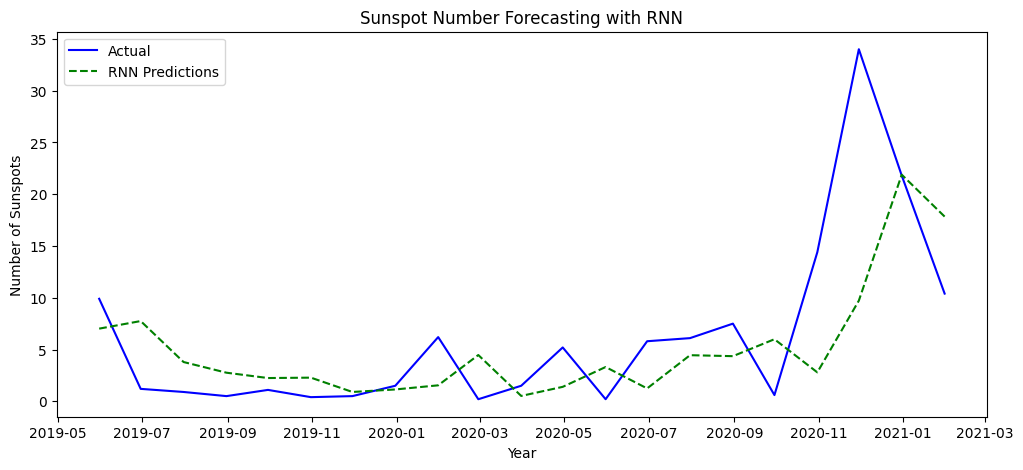

In [28]:
# Visualization of predictions
plt.figure(figsize=(12, 5))
plt.plot(df.index[start-len(y_test):], y_test_original[start:], label="Actual", color='blue')
plt.plot(df.index[start-len(y_test):], rnn_predictions_inv[start:], label="RNN Predictions", color='green', linestyle='dashed')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of Sunspots")
plt.title("Sunspot Number Forecasting with RNN")
plt.show()